In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import numpy as np
import glob
import os
import cv2
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import * 
from tensorflow.keras.preprocessing import image
from sklearn.preprocessing import *
#import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

from scipy import stats
from datetime import *
import datetime

import tensorflow as tf
from tensorflow.keras import models, layers
#from tensorflow.keras.models import Model
#from tensorflow.keras.layers import BatchNormalization, Activation, Flatten
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau,ModelCheckpoint, TerminateOnNaN, EarlyStopping, TensorBoard,CSVLogger
import datetime
import os
from tensorflow.keras import backend as K
#from tensorflow.keras.models import load_model, save_model
#from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array,load_img
import keras
from keras.preprocessing.image import ImageDataGenerator,img_to_array,load_img

import warnings
warnings.filterwarnings('ignore')


In [ ]:
import pickle
import datetime
from PIL import Image
import cv2
from google.colab.patches import cv2_imshow

luxury_seg = pickle.load(open('/content/gdrive/MyDrive/cs2/data/pickle/luxury_seg.pkl', 'rb'))
medium_seg = pickle.load(open('/content/gdrive/MyDrive/cs2/data/pickle/medium_seg.pkl','rb'))
cmp_cnt =  pickle.load(open('/content/gdrive/MyDrive/cs2/data/pickle/cmp_cnt.pkl','rb'))
ohe = pickle.load(open('/content/gdrive/MyDrive/cs2/data/pickle/ohe.pkl', 'rb'))
feature_labels = pickle.load(open('/content/gdrive/MyDrive/cs2/data/pickle/labels.pkl', 'rb'))
scaler = pickle.load(open('/content/gdrive/MyDrive/cs2/data/pickle/scaler.pkl', 'rb'))
gbdt = pickle.load(open('/content/gdrive/MyDrive/cs2/data/imgonly_gbr_model.pkl', 'rb'))


In [ ]:
def feature_engg(data, col1, col2, col3, col4, col5):
  
  '''takes data : train/test dataframe,
     col1       : expiry_date,
     col2       : cost-of-vehicle,
     col3       : insurance company,
     col4       : max coverage
     col5       : min coverage
     returns    : newly computed feature in dataframe'''


  today = datetime.datetime(2021,9,12,0,0,0)
  #luxury_seg = np.percentile(data[col2], 75)
  #medium_seg = np.percentile(data[col2], 25)
  #cmp_cnt = data[col3].value_counts()


  data[col1]           = data[col1].apply(pd.to_datetime)
  data['year']         = data[col1].apply(lambda x : x.year)
  data['month']        = data[col1].apply(lambda x: x.month)
  data['month_day']    = data[col1].apply(lambda x: x.day)
  data['yr_day']       = data[col1].apply(lambda x: x.dayofyear)
  data['week_day']     = data[col1].apply(lambda x: x.weekday())
  data['week_no']      = data[col1].apply(lambda x: x.week)
  data['lux_seg']      = data[col2].apply(lambda x: 1 if x>luxury_seg else 0)
  data['med_seg']      = data[col2].apply(lambda x: 1 if (x<luxury_seg and x>medium_seg) else 0)
  data['budget_seg']   = data[col2].apply(lambda x: 1 if (x<medium_seg) else 0)
  data['age_of_insur'] = data[col1].apply(lambda x: round(abs((today-x).days)/365,2))

  md_age = np.median(data['age_of_insur'])

  data['cmpny_count']       = data[col3].apply(lambda x: cmp_cnt[x])
  data['range_of_coverage'] = data[col4]-data[col5]
  data['insuran_pd']        = data['age_of_insur'].apply(lambda x: 1 if x > md_age else 0)
  data['low_expire']        = data['age_of_insur'].apply(lambda x: 1 if x < 2 else 0)
  data['med_expire']        = data['age_of_insur'].apply(lambda x: 1 if (x > 2 and x<5) else 0)
  data['hig_expire']        = data['age_of_insur'].apply(lambda x: 1 if  x>5 else 0)
  data['cost_grt_20k']      = data[col4].apply(lambda x : 1 if x > 20000 else 0)

  return data

In [ ]:
path = '/content/gdrive/MyDrive/cs2/data/model3/model3_deepl.h5'
def model_pred(frame, image_path):
  
  print(f'| Original image : |')
  print('-'*20)
  print(' ')
  img_g = cv2.imread(img[0],-1)
  img_g = cv2.cvtColor(img_g, cv2.COLOR_BGR2RGB)
  cv2_imshow(img_g)                                         ##cv2.imshow
  print(' ')
  best_model = tf.keras.models.load_model(path)
  original_image = cv2.imread(frame[image_path].values[0], cv2.IMREAD_UNCHANGED)
  image = cv2.resize(original_image, (224, 224))
  image = img_to_array(image)
  image = image.reshape((1,224, 224, 3))
  image = np.array(image, dtype="float") / 255.0 
  prediction = best_model(image)
  frame['Condition'] = [1 if prediction[0][0]>0.5 else 0]

  return frame



In [ ]:
def ohe_transform_inter(arry, label, dataframe):

  '''takes arry : one-hot encoded columns,
          labels: names to be given to arry
        returns : final dataframe after concatating one hot columns with rest of features and droping some of them not usefull'''

  ohe_df = pd.DataFrame(arry, columns=label)   
  final = pd.concat([dataframe, ohe_df], axis=1)  
  final.drop(['Image_path','Insurance_company', 'Expiry_date'], axis=1, inplace=True)

  return final

In [ ]:
def pipeline():

  data_frame = pd.DataFrame(list(zip(img,compy, cost_veh, min_cov, exp_date, max_cov)) ,columns=['Image_path', 'Insurance_company', 'Cost_of_vehicle', 'Min_coverage', 'Expiry_date', 'Max_coverage'])
  fe_df = feature_engg(data_frame, 'Expiry_date', 'Cost_of_vehicle', 'Insurance_company', 'Max_coverage', 'Min_coverage')
  cond_frm = model_pred(fe_df, 'Image_path')
  test_arr1 = ohe.transform(cond_frm['Insurance_company'].values.reshape(-1,1)).toarray()
  final_test_1 = ohe_transform_inter(test_arr1, feature_labels, cond_frm)

  amount = round(gbdt.predict(final_test_1)[0], 3)

  print(f'Claim amount predicted is {amount}')

  return 


| Original image : |
--------------------
 


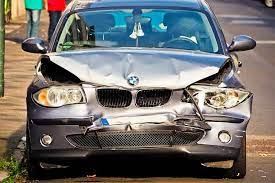

 
Claim amount predicted is 4071.467


In [ ]:
img = ['/content/gdrive/MyDrive/cs2/data/download.jpeg']
compy = ['B']
cost_veh = [41500.0]
min_cov  = [2000.0]
exp_date = ['12-12-2022']
max_cov  = [21000.0]

amount = pipeline()

| Original image : |
--------------------
 


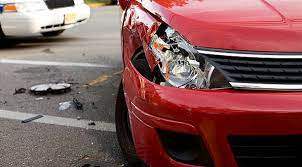

 
Claim amount predicted is 4071.467


In [ ]:
img = ['/content/gdrive/MyDrive/cs2/data/img/dc1.jpg']
compy = ['C']
cost_veh = [32500.0]
min_cov  = [5000.0]
exp_date = ['12-12-2026']
max_cov  = [15000.0]

amount = pipeline()

| Original image : |
--------------------
 


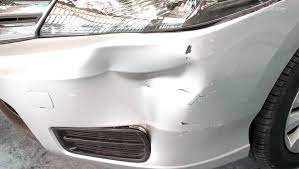

 
Claim amount predicted is 4071.467


In [ ]:
img = ['/content/gdrive/MyDrive/cs2/data/img/dc2.jfif']
compy = ['AA']
cost_veh = [40500.0]
min_cov  = [8000.0]
exp_date = ['12-08-2028']
max_cov  = [15000.0]

amount = pipeline()

| Original image : |
--------------------
 


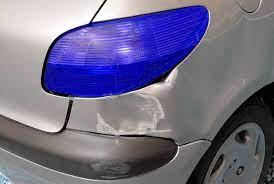

 
Claim amount predicted is 4071.467


In [ ]:
img = ['/content/gdrive/MyDrive/cs2/data/img/dc3.jfif']
compy = ['AA']
cost_veh = [28500.0]
min_cov  = [1500.0]
exp_date = ['12-08-2027']
max_cov  = [3000.0]

amount = pipeline()

| Original image : |
--------------------
 


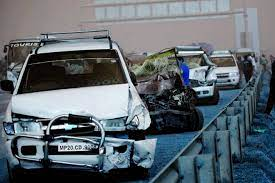

 
Claim amount predicted is 4135.6


In [ ]:
img = ['/content/gdrive/MyDrive/cs2/data/img/dc4.jfif']
compy = ['BB']
cost_veh = [40700.0]
min_cov  = [1017.5]
exp_date = ['03-01-2022']
max_cov  = [10253]

amount = pipeline()

| Original image : |
--------------------
 


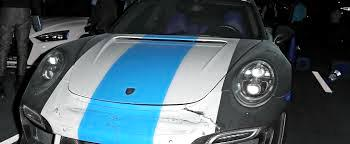

 
Claim amount predicted is 4071.467


In [ ]:
img = ['/content/gdrive/MyDrive/cs2/data/testImages/img_4538519.jpg']
compy = ['AA']
cost_veh = [23600.0]
min_cov  = [590.0]
exp_date = ['12-04-2025']
max_cov  = [5978]

amount = pipeline()

| Original image : |
--------------------
 


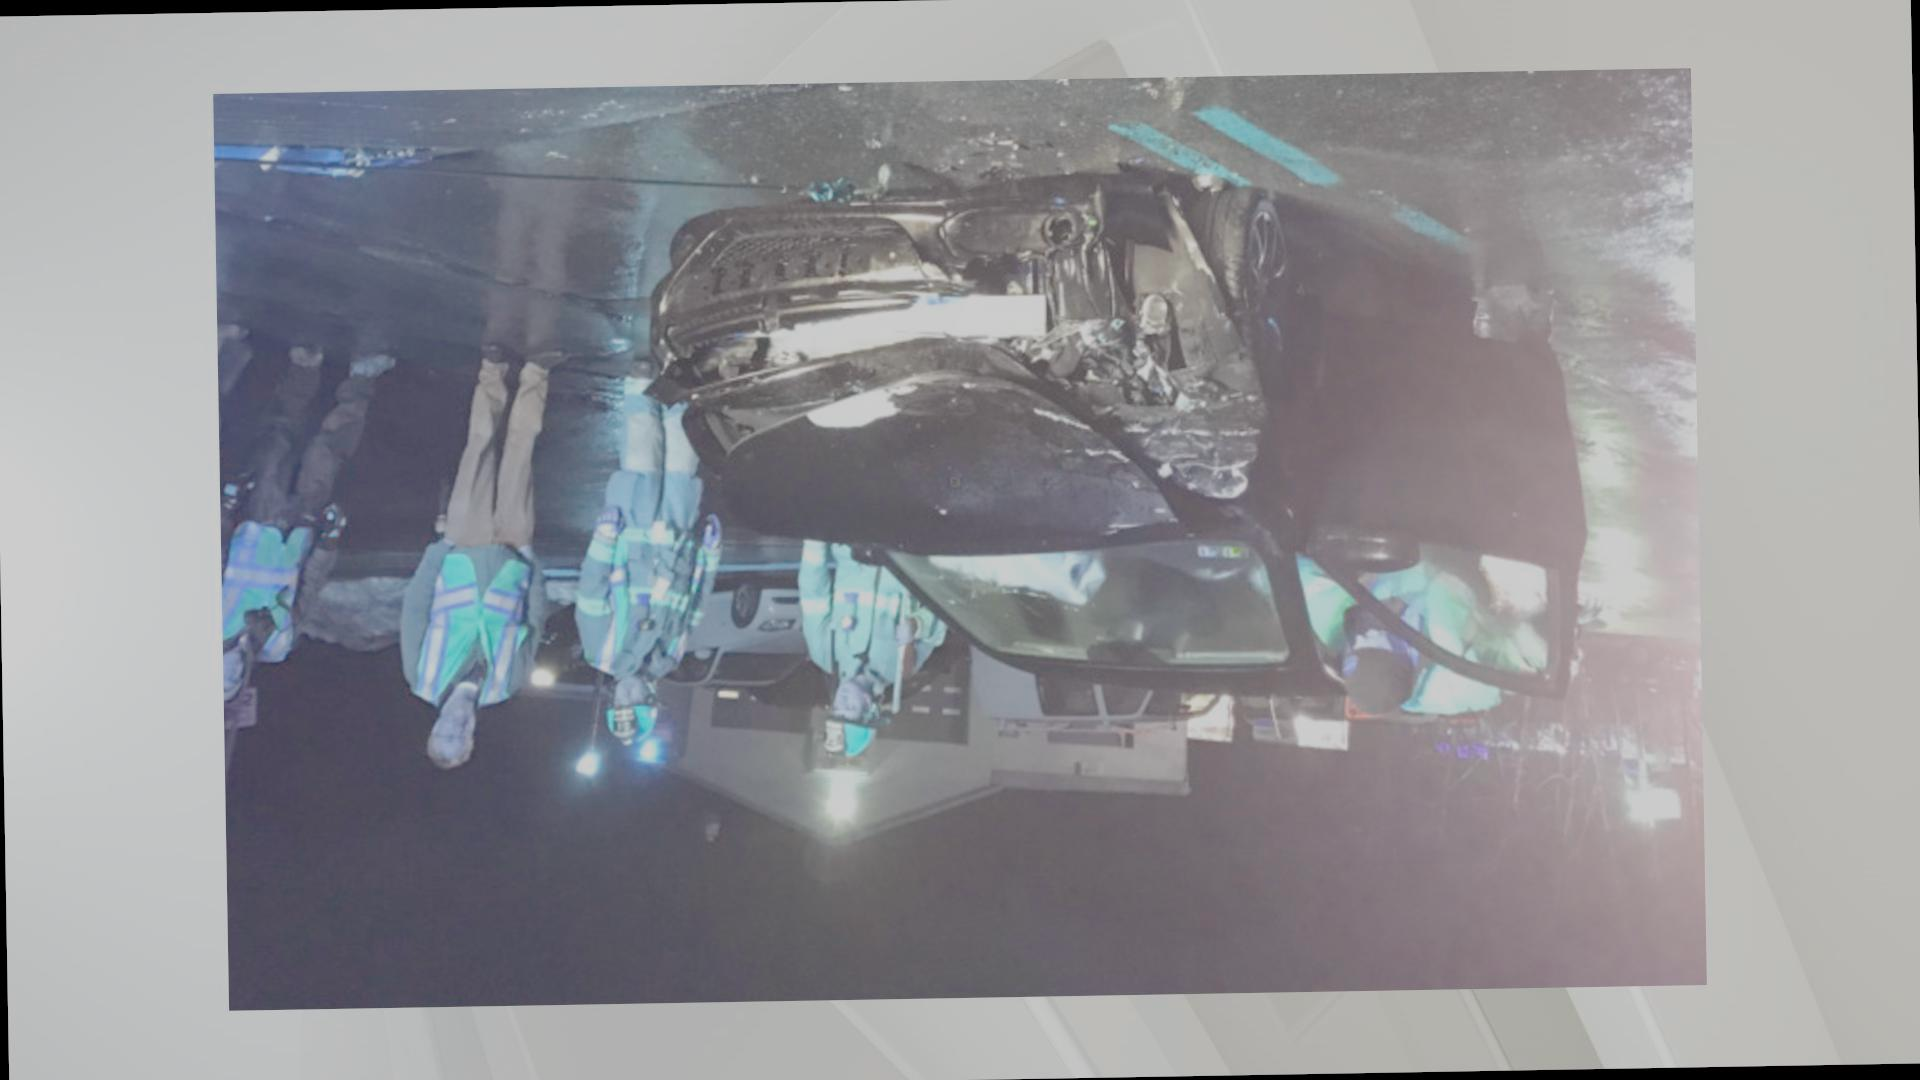

 
Claim amount predicted is 4135.6


In [ ]:
img = ['/content/gdrive/MyDrive/cs2/data/testImages/img_4517008.jpg']
compy = ['BB']
cost_veh = [40700.0]
min_cov  = [1017.5]
exp_date = ['03-01-2022']
max_cov  = [10253]

amount = pipeline()

| Original image : |
--------------------
 


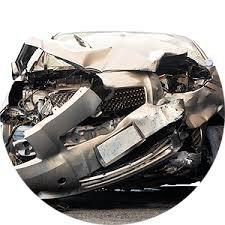

 
Claim amount predicted is 4071.467


In [ ]:
img = ['/content/gdrive/MyDrive/cs2/data/testImages/img_7765468.jpg']
compy = ['BQ']
cost_veh = [34500.0]
min_cov  = [862.5]
exp_date = ['14-12-2022']
max_cov  = [8703]

amount = pipeline()

| Original image : |
--------------------
 


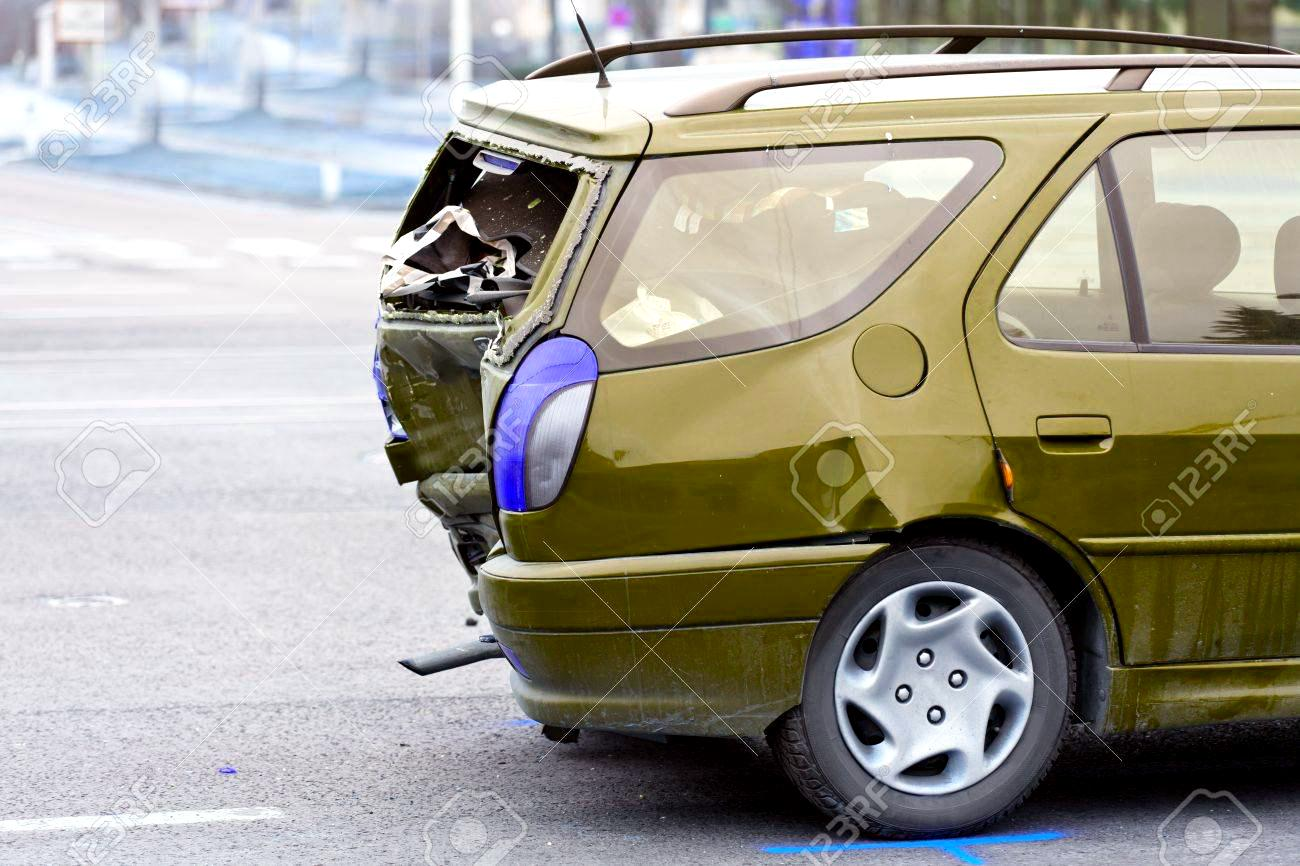

 
Claim amount predicted is 4071.467


In [ ]:
img = ['/content/gdrive/MyDrive/cs2/data/testImages/img_7766331.jpg']
compy = ['O']
cost_veh = [38300.0]
min_cov  = [957.5]
exp_date = ['16-10-2024']
max_cov  = [9653]

amount = pipeline()

| Original image : |
--------------------
 


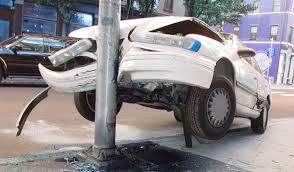

 
Claim amount predicted is 4135.6


In [ ]:
img = ['/content/gdrive/MyDrive/cs2/data/testImages/img_4517740.jpg']
compy = ['DA']
cost_veh = [26200.0]
min_cov  = [655]
exp_date = ['10-08-2022']
max_cov  = [6628]

amount = pipeline()

| Original image : |
--------------------
 


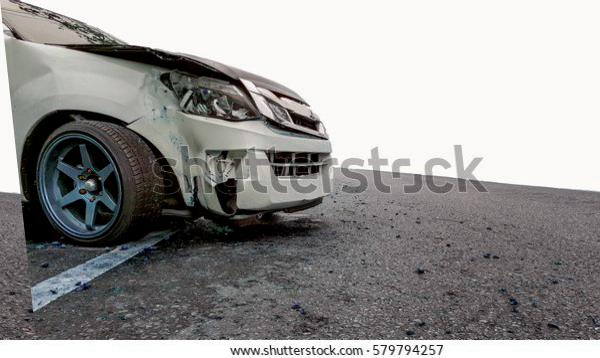

 
Claim amount predicted is 4135.6


In [ ]:
img = ['/content/gdrive/MyDrive/cs2/data/testImages/img_4515070.jpg']
compy = ['RE']
cost_veh = [51400.0]
min_cov  = [185.0]
exp_date = ['14-11-2021']
max_cov  = [12928]

amount = pipeline()

| Original image : |
--------------------
 


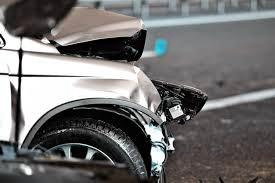

 
Claim amount predicted is 4071.467


In [ ]:
img = ['/content/gdrive/MyDrive/cs2/data/testImages/img_4635251.jpg']
compy = ['RE']
cost_veh = [27600.0]
min_cov  = [690.0]
exp_date = ['17-05-2028']
max_cov  = [24049.68]

amount = pipeline()

| Original image : |
--------------------
 


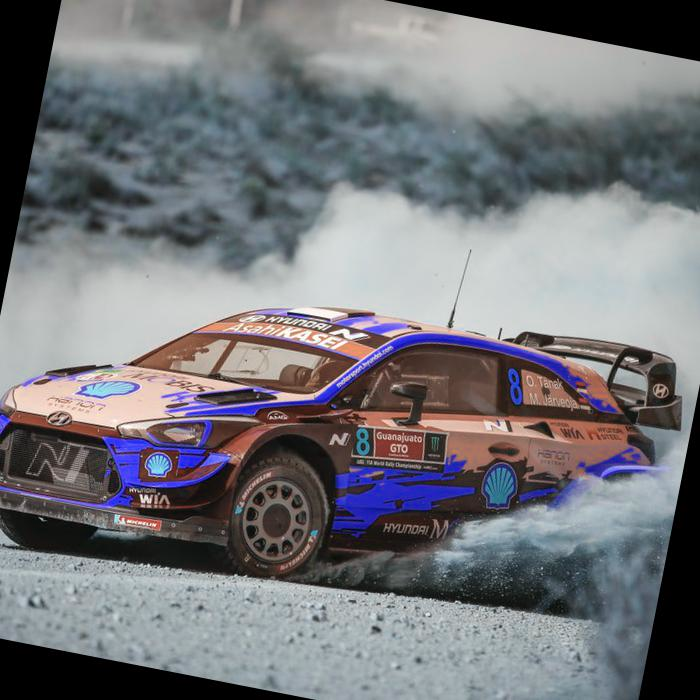

 
Claim amount predicted is 4135.6


In [ ]:
img = ['/content/gdrive/MyDrive/cs2/data/testImages/img_4538466.jpg']
compy = ['AC']
cost_veh = [53100.0]
min_cov  = [1327.5]
exp_date = ['02-12-2022']
max_cov  = [13353]

amount = pipeline()

| Original image : |
--------------------
 


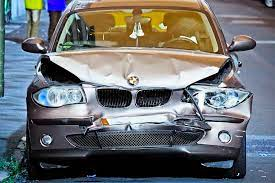

 
Claim amount predicted is 4135.6


In [ ]:
img = ['/content/gdrive/MyDrive/cs2/data/img/download.jpeg']
compy = ['AC']
cost_veh = [53100.0]
min_cov  = [1327.5]
exp_date = ['02-12-2022']
max_cov  = [13353]

amount = pipeline()

| Original image : |
--------------------
 


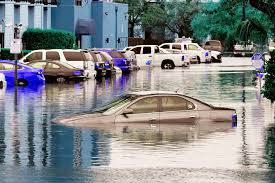

 
Claim amount predicted is 4071.467


In [ ]:
img = ['/content/gdrive/MyDrive/cs2/data/testImages/img_4635378.jpg']
compy = ['RE']
cost_veh = [49300.0]
min_cov  = [1232.5]
exp_date = ['07-08-2025']
max_cov  = [12403]

amount = pipeline()

| Original image : |
--------------------
 


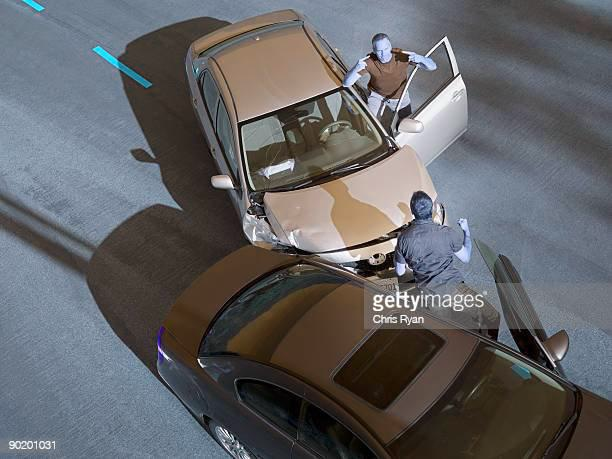

 
Claim amount predicted is 4071.467


In [ ]:
img = ['/content/gdrive/MyDrive/cs2/data/testImages/img_4538654.jpg']
compy = ['BC']
cost_veh = [39100.0]
min_cov  = [977.5]
exp_date = ['22-02-2026']
max_cov  = [9853]

amount = pipeline()

| Original image : |
--------------------
 


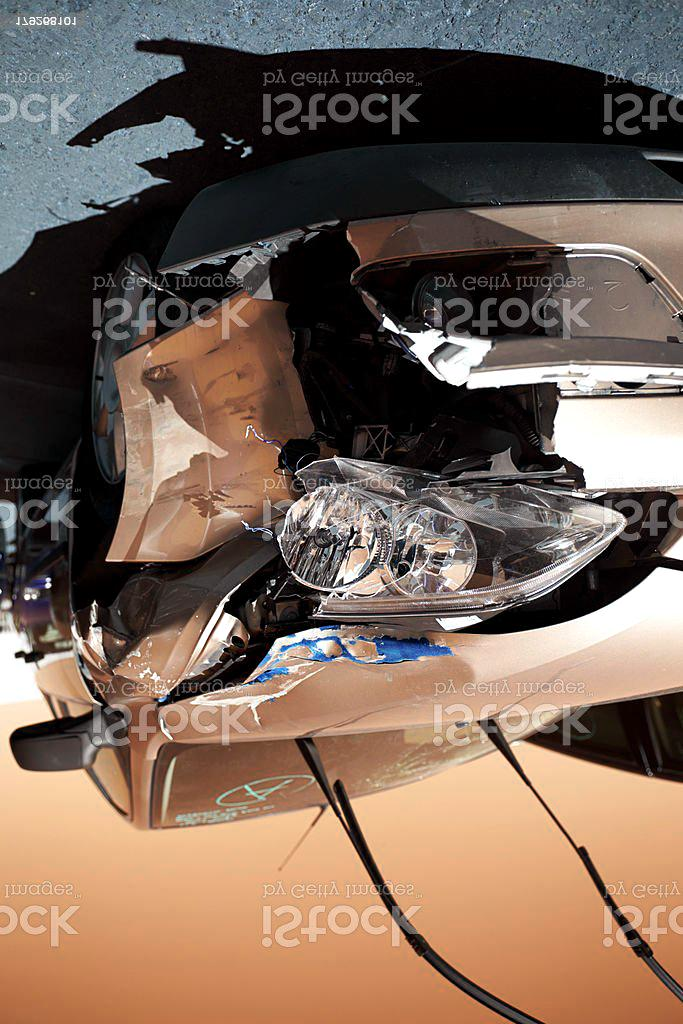

 
Claim amount predicted is 4071.467


In [ ]:
img = ['/content/gdrive/MyDrive/cs2/data/testImages/img_4634997.jpg']
compy = ['DA']
cost_veh = [53200.0]
min_cov  = [1330]
exp_date = ['09-09-2026']
max_cov  = [13378]

amount = pipeline()

| Original image : |
--------------------
 


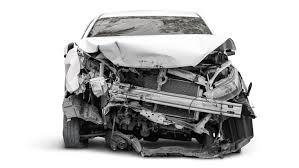

 
Claim amount predicted is 4071.467


In [ ]:
img = ['/content/gdrive/MyDrive/cs2/data/img/dc5.jfif']
compy = ['DA']
cost_veh = [53200.0]
min_cov  = [1330]
exp_date = ['09-09-2026']
max_cov  = [13378]

amount = pipeline()

| Original image : |
--------------------
 


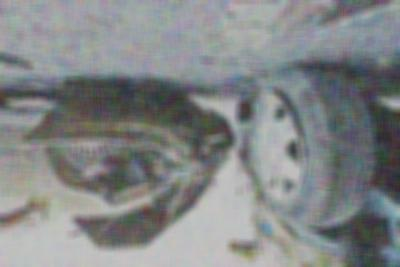

 
Claim amount predicted is 4071.467


In [ ]:
img = ['/content/gdrive/MyDrive/cs2/data/testImages/img_4637390.jpg']
compy = ['AC']
cost_veh = [43700]
min_cov  = [1092.5]
exp_date = ['2023-11-28']
max_cov  = [11003.00]

amount = pipeline()

| Original image : |
--------------------
 


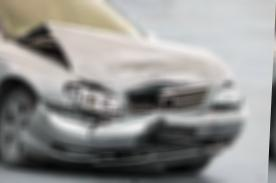

 
Claim amount predicted is 4071.467


In [ ]:
img = ['/content/gdrive/MyDrive/cs2/data/trainImages/img_7764995.jpg']
compy = ['BQ']
cost_veh = [50700.0]
min_cov  = [1267.5]
exp_date = ['2025-07-10']
max_cov  = [12753.00]

amount = pipeline()

| Original image : |
--------------------
 


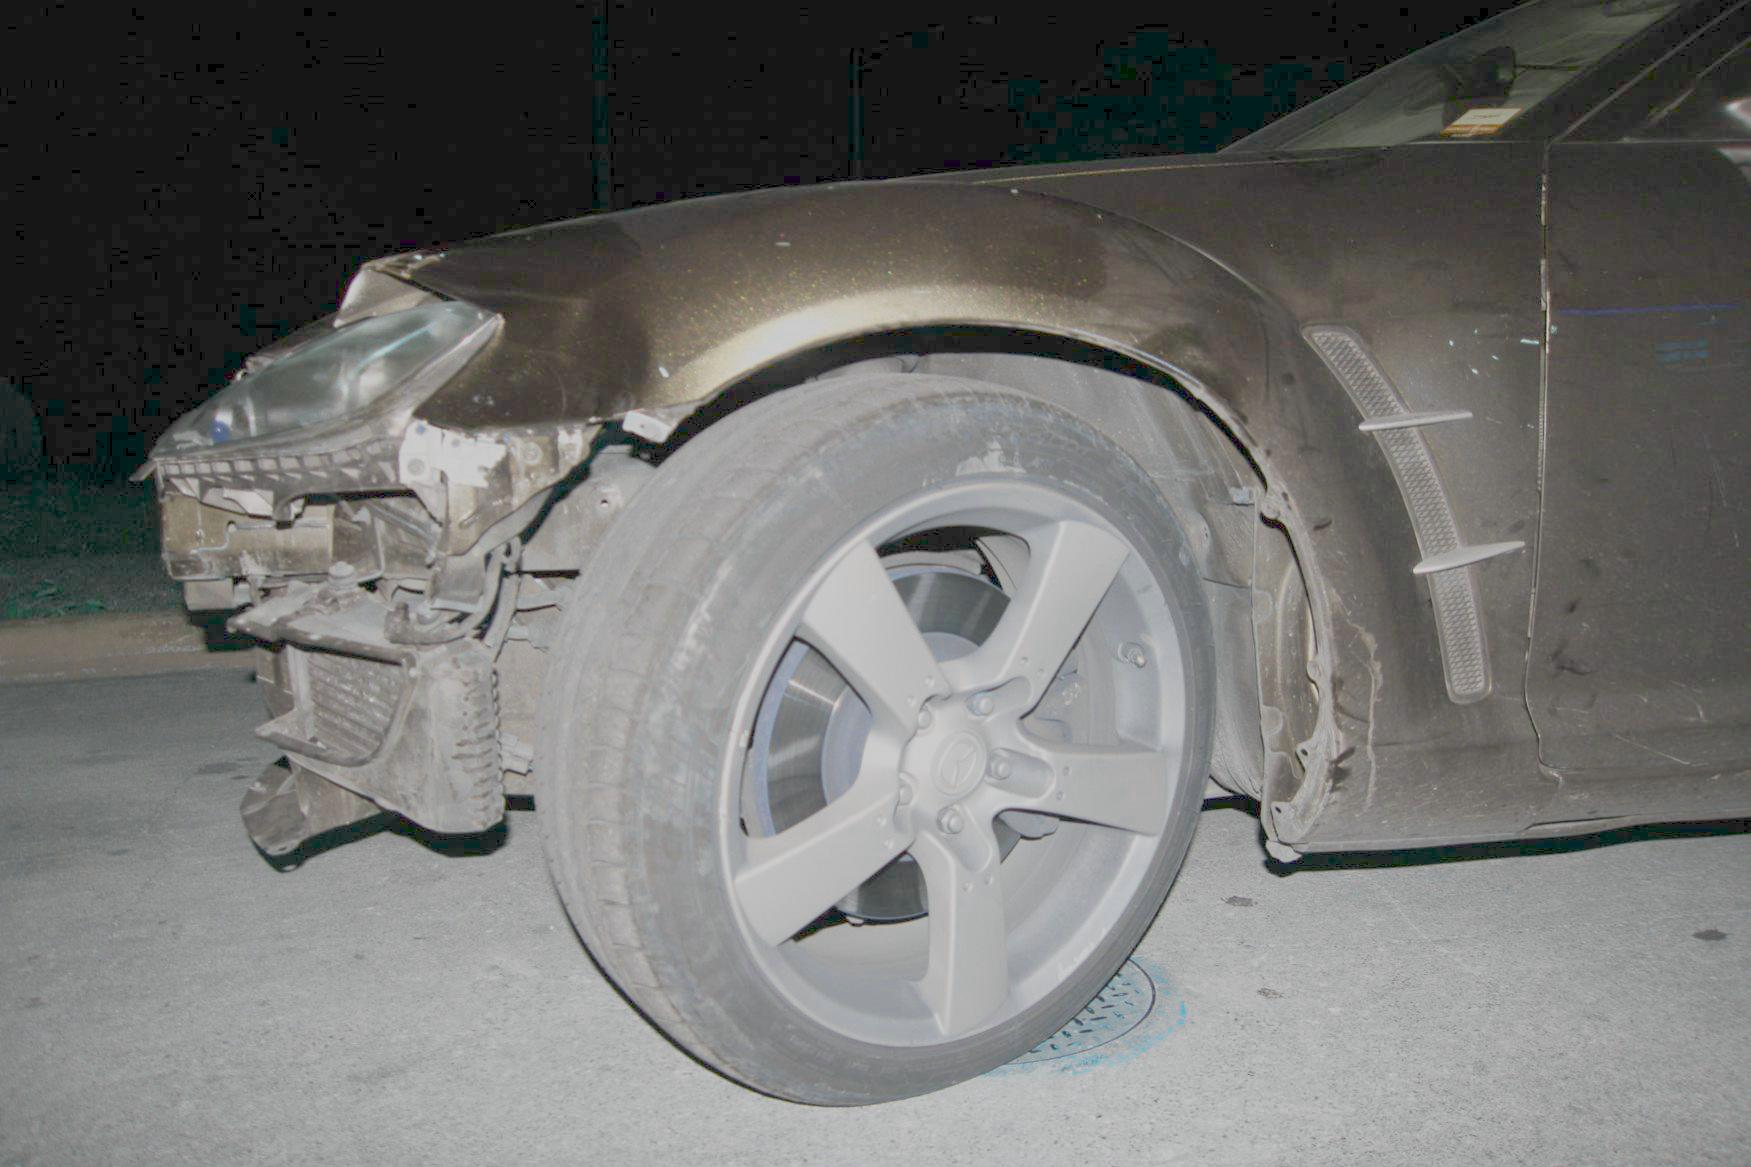

 
Claim amount predicted is 4135.6


In [ ]:
img = ['/content/gdrive/MyDrive/cs2/data/trainImages/img_4515101.jpg']
compy = ['A']
cost_veh = [32200.0]
min_cov  = [830.0]
exp_date = ['2022-10-10']
max_cov  = [8378.00]

amount = pipeline()

| Original image : |
--------------------
 


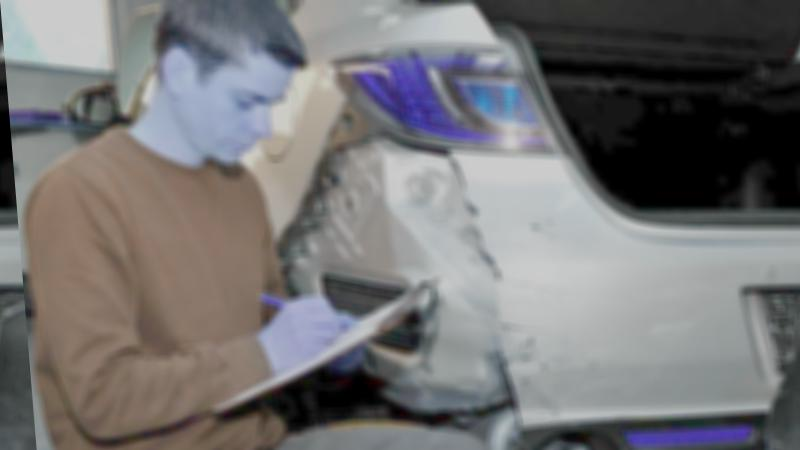

 
Claim amount predicted is 4071.467


In [ ]:
img = ['/content/gdrive/MyDrive/cs2/data/trainImages/img_4637503.jpg']
compy = ['AA']
cost_veh = [31400.0]
min_cov  = [785.0]
exp_date = ['2022-11-25']
max_cov  = [7928.0]

amount = pipeline()